## Bagging 모델들의 다양성 증진 시도 및 해석 가능성 확인
##### 본 tutorial은 `랜덤포레스트의 다양성을 증진할 수 있는 방법`에 대해 알아보고, 이들의 `RF 모델의 설명 가능성과 Explainable Boosting Machine (EBM)의 설명가능성을 비교`하는 것을 목적으로 한다.
- 실험 1) 개별 weak learner custom에 따른 성능 차이 확인
- 실험 2) Bootstrap custom에 따른 성능 차이 확인

#### 실험1: 개별 weak learner custom에 따른 성능 차이 확인
- Random Forest는 weak learner의 분기마다 임의의 변수들을 랜덤하게 샘플링 한 뒤에, 그 안에서 information gain을 최대화하는 변수를 찾는다.
    => 모든 변수에 대해서 information gain을 찾지 않는다. (제약 설정)
- 개별 tree의 분기에 사용하는 변수의 수를 제한하여 학습된 의사결정나무가 모든 변수를 사용한 의사결정나무에 비해서 1:1로 비교할 경우 정확도가 상대적으로 낮지만, 집단간 비교 시 다양성 확보로 인해 시너지 효과를 낼 수 있음을 의미한다. (비즈니스 애널리틱스 강필성 교수님 수업 중 참고)
- `개별 트리들에 있어서 임의 변수 추출을 하지 않고, 모든 변수를 사용하면 어떨까?` -> 모델에 입력되는 학습데이터도 붓스트랩을 통해 달라지기에 충분한 '다양성'을 확보했다고 생각 -> 일반적인 Decision Tree를 사용해서 성능 확인

In [193]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
import tqdm
from typing import Tuple
from typing import Dict

In [194]:
"""데이터셋 생성"""
X, y = make_classification(
            n_samples = 10000, # 10000개의 데이터셋
            n_informative=15, # 20개의 독립변수
            n_redundant=2, # 독립변수와 종속변수 간의 상관관계 존재 개수
            n_classes=2, # 독립변수 중 다른 독립 변수의 선형 조합으로 나타나는 성분의 수
            weights = [.9], # 2개의 class, 클래스 비율
            random_state = 42)
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,10.377175,0.791082,-1.578970,-0.629338,-4.271231,-1.486054,0.907795,0.902715,-1.363631,2.551098,2.170168,3.770187,-2.245644,0.410449,-0.917343,0.455528,0.122309,-0.364101,-4.177382,1.451621
1,-6.793029,-0.525945,-1.854669,2.843386,2.950132,3.216077,0.372532,-1.116148,-1.726772,-1.064258,1.256504,-1.240099,-1.549392,-1.876169,2.972222,-2.102989,-3.346343,-1.794734,3.398536,-1.063641
2,0.994392,0.163488,-1.331628,1.058797,-3.288186,1.433961,1.204198,0.957120,1.624522,1.467952,-2.140157,3.883353,3.180055,2.326034,3.960384,1.445266,0.029692,0.104027,-0.148485,-1.283163
3,10.645223,-1.319847,-2.972818,-1.796683,-0.632752,-0.361741,2.213520,2.720563,-3.497270,2.191274,0.582128,6.571167,0.493361,0.914744,0.776501,4.621038,-0.355681,0.126882,-1.482002,0.154268
4,-3.000188,-0.555664,-2.492928,0.625268,-0.252953,-3.733850,-1.268464,0.862210,3.289753,3.475318,-4.473016,-2.527463,-0.201719,-1.929009,-1.165762,-1.221145,-1.451504,1.789955,1.394556,0.880454


In [201]:
"""
1)변수 임의 추출이 아닌 모든 변수를 사용한 트리 사용
    # 1. 입력 데이터 형태 지정
    # 2-1. 개별 트리 생성 및 저장
    # 2-2. 붓스트랩 생성
    # 3. soft voting 방식을 사용하여 aggregating
"""
class BaseLearner_Variation_Forest():
    def __init__(self, n_estimators: int = 100, max_features: str = "sqrt",min_samples_leaf: int = 6, random_state: int = None) -> None: # 리턴 없음
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        
      
    def fit(self, X: pd.DataFrame, y: np.array):
        
        ### 1. 입력 데이터 형태 지정 -> dataset은 데이터프레임 형태 / y는 np.array
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        assert isinstance(y, np.ndarray)
        
        ### 2-1. 개별 트리 생성 및 저장
        base_learner_list = [] # n_estimators 만큼의 트리 저장
        for i in range(self.n_estimators):
            # 붓스트랩핑
            X_bootstrap, y_bootstrap = self._bootstrap_sample(X, y)
        
            # weak learner 적용
            weak_learner = DecisionTreeClassifier(
                    max_features = self.max_features,
                    min_samples_leaf = self.min_samples_leaf,
                    random_state = self.random_state+i)
            weak_learner.fit(X_bootstrap, y_bootstrap)
            base_learner_list.append(weak_learner)

        self.base_learner_list = base_learner_list
        return self
        
    ### 2-2. 붓스트랩 생성
    def _bootstrap_sample(self, X: pd.DataFrame, y: np.ndarray) -> Tuple[pd.DataFrame, np.ndarray]: ##############################
        n_samples = X.shape[0]
        indexs = np.random.randint(low=0, high=n_samples, size=n_samples) # 붓스트랩에 사용할 인덱스 복원추출
        X_bootstrap = X.iloc[indexs]; y_bootstrap = y[indexs] # x와 y의 붓스트랩 샘플
        return X_bootstrap, y_bootstrap

    ### 3. Aggregating에 있어서 soft voting 방식 사용
    def predict_proba(self, X: pd.DataFrame):
        probas = np.asarray([clf.predict_proba(X) for clf in self.base_learner_list])
        avg_predict = np.average(probas, axis=0) # 관측치별 예측 확률 계산
        return avg_predict

In [202]:
"""평가 함수"""
def evaluation_models(models: Dict, X, y, n_trials: int) -> pd.DataFrame: # 데이터 프레임 형태로 반환
    perf = pd.DataFrame()

    seeds = range(n_trials) # n_trials번 돌린 값의 평균을 사용하여 성능 평가
    for name, model in tqdm.tqdm(models.items()):
        p = evaluate_performance(model, X, y, name, seeds=seeds)
        perf = perf.append(p)
    
    perf = perf.sort_values(['auc_test'], ascending=False)
    return perf


def evaluate_performance(model, X, y, model_name = "", test_size = .2, seeds = [42]):
    
    auc_test = []
    auc_train = []
    # seed 개수만큼 반복
    for seed in seeds:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed, stratify = y)
            
        model.fit(X_train, y_train)
        # class 1로 예측할 확률만 가져오기
        metric_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) 
        auc_test.append(metric_test)
        metric_train = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
        auc_train.append(metric_train)
        
    auc_train = round(np.mean(auc_train),4)
    auc_test = round(np.mean(auc_test),4)
    
    data = [model_name, auc_train, auc_test, auc_train - auc_test, len(seeds)]
    return pd.DataFrame([data], columns = ['model','auc_train', 'auc_test', 'delta','n_models'])

In [204]:
forest_parameters = {"n_estimators": 100,"min_samples_leaf":5, "max_features": 'sqrt', "random_state": 42}

evaluation_models(models={
    'Vanilla RF' : RandomForestClassifier(**forest_parameters),
    'BaseLearner_Variation_Forest RF' : BaseLearner_Variation_Forest(**forest_parameters)
    }, X=X, y=y, n_trials=20
)

  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\ROHSEU~1\AppData\Local\Temp/ipykernel_32012/3391097967.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf = perf.append(p)
 50%|█████     | 1/2 [00:47<00:47, 47.81s/it]C:\Users\ROHSEU~1\AppData\Local\Temp/ipykernel_32012/3391097967.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf = perf.append(p)
100%|██████████| 2/2 [01:58<00:00, 59.17s/it]


,model,auc_train,auc_test,delta,n_models
0,BaseLearner_Variation_Forest RF,0.9999,0.9584,0.0415,20
0,Vanilla RF,0.9994,0.9576,0.0418,20


[해석]
- 배깅에 있어서 모든 붓스트랩의 weak learner들에 모든 변수를 사용하는 것이 '다양성'을 줄여 최종적으로 성능 또한 떨어지는지 알고 싶었다.
- 따라서 Weak learner의 분기에 있어서 임의 변수 추출을 사용하는 랜덤 포레스트와 달리 변형한 방법은 모든 변수를 사용한다.
- 결과는 미미하지만 test셋에 대해 정확도가 조금 더 오른 것을 확인할 수 있었다. 과적합이 더 된 것 같기에 다른 데이터셋에 대해서도 확인을 해봐야하나 간단한 테스트에서는 나쁘지 않은 성능을 도출하는 것을 알 수 있었다.
- 이후에는 매우 중요한 변수와 그렇지 않은 변수들로, 변수들 간에 극단적인 기여도 차이를 보이는 데이터셋에 대해서 검증을 해볼 예정이다.

---

#### 실험2: Bootstrap custom을 통한 성능 변화 확인
- Bootstrap을 통해 학습데이터의 노이즈 ($\epsilon$)의 정도를 게속적으로 바꿔줌으로서 좋은 뜻의 데이터 왜곡을 수행한다.
- 복원 추출을 사용하기에 동일한 관측치가 하나의 붓스트랩에 여러 개 포함될 수 있다. 같은 관측치의 증가는 정보량의 증가라고 할 수 있는데, 그 이유는 다음과 같다. 전체 데이터의 분포 자체에서 중복된 데이터에 대한 가중치가 생기는 것이다. 혼자 떨어져 있는 관측치를 original dataset에서는 구분하지 못하나 이를 복원추출을 통해 여러개 뽑는다면 이는 중복된 관측치에 가중치가 부여되게 하여 해당 관측치가 분류될 수 있게 된다.
- `일반적인 붓스트랩 방식이 아닌 class 간의 불균형을 고려한 붓스트랩 방식을 통해 학습 데이터의 왜곡을 수행하면 어떨까?` -> 기존의 붓스트랩이 적은 class의 관측치들에 대해 가중치를 주어서 학습 데이터를 생성한다고 하더라도 이는 한계가 존재할 것이라 생각 -> 기존의 방식이 아닌 다른 방식의 붓스트랩 적용

In [209]:
"""
2-1) 각 붓스트랩이 클래스의 불균형 비율을 그대로 가져가게 하기
- 위에서 만든 class에서 bootstrap 샘플링 기법 변환
- 사이킷런 라이브러릴 활용하여 소수 클래스 추출 -> 클래스 비율 맞추기
"""
from sklearn.utils import resample

class Stratified_Bootstraping_Forest(BaseLearner_Variation_Forest):    
    def _bootstrap_sample(self, X: pd.DataFrame, y: np.ndarray) -> Tuple[pd.DataFrame, np.ndarray]: # 반환 형식
        X_bootstrap, y_bootstrap = resample(X, y, stratify = y) # target class의 비율에 맞춰서 resampling
        return X_bootstrap, y_bootstrap

In [210]:
"""
2-2) 소수 클래스의 사이즈 만큼 다수 클래스 붓스트래핑
- 위에서 만든 class에서 bootstrap 샘플링 기법 변환
- minority 클래스에 대해서 해당 클래스의 수 만큼 복원추출하고, 다수 클래스를 소수 클래스 수에 맞춰서 뽑기
    # 1. Minority 클래스 찾기
    # 2. Minority 클래스 붓스트래핑
    # 3. Majority 클래스를 minority만큼 붓스트래핑
    # 4. 합치기
"""
class Balance_Bootstraping_Forest(BaseLearner_Variation_Forest):
    def _bootstrap_sample(self, X: pd.DataFrame, y: np.ndarray) -> Tuple[pd.DataFrame, np.ndarray]:
        ### 1. Minority 클래스 찾기
        counts = np.bincount(y)
        minority_class = np.argmin(counts)
        n_minority = counts[minority_class] # 적은 클래스의 개수 

        ### 2. Minority 클래스 붓스트래핑
        indices_minority = np.random.choice(
            np.where(y == minority_class)[0], 
            size = n_minority,
            replace = True)

        ### 2. Majority 클래스를 minority만큼 붓스트래핑
        indices_majority = np.random.choice(
            np.where(y != minority_class)[0],
            size = n_minority,
            replace = True)
        
        ### 3. 합치기
        indices = np.hstack([indices_majority, indices_minority])
        np.random.shuffle(indices) # 셔플링
        
        X_bootstrap = X.iloc[indices]
        y_bootstrap = y[indices]
        return X_bootstrap, y_bootstrap


In [212]:
"""
2-3) 전체 개수의 50:50으로 소수 클래스와 다수 클래스 비율 맞추기
- 위에서 만든 class에서 bootstrap 샘플링 기법 변환
- 전체 개수의 절반만큼 소수 클래스에서 복원추출하고, 나머지 절반은 다수 클래스에서 복원추출하기
    # 1. 전체 개수에 대해서 50:50으로 나누기
    # 2. 다수 클래스 선택
    # 3. 소수 클래스 붓스트랩
    # 4. 다수 클래스 붓스트랩
"""
class Same_Ratio_Bootstraping_Forest(BaseLearner_Variation_Forest):
    def _bootstrap_sample(self, X: pd.DataFrame, y: np.ndarray) -> Tuple[pd.DataFrame, np.ndarray]:
        n_majority = n_minority = int(len(y) / 2)
        if len(y) % 2 == 1:
            n_majority -= 1 
        assert n_minority + n_majority == len(y)

        ### 2. 다수 클래스 선택
        counts = np.bincount(y)
        majority_class = np.argmax(counts)

        ### 3. 다수 클래스 붓스트랩
        indices_minority = np.random.choice(
            np.where(y != majority_class)[0],
            size = n_minority,
            replace = True)

        ### 3. 소수 클래스 붓스트랩
        indices_majority = np.random.choice(
            np.where(y == majority_class)[0],
            size = n_majority,
            replace = True)
            
        indices = np.hstack([indices_majority, indices_minority]) # 합치기
        np.random.shuffle(indices) # in-place
        
        X_bootstrap = X.iloc[indices]
        y_bootstrap = y[indices]
        return X_bootstrap, y_bootstrap

In [214]:
forest_parameters = {"n_estimators": 100,"min_samples_leaf":5, "max_features": 'sqrt', "random_state": 42}

evaluation_models(models={
    'Vanilla RF' : RandomForestClassifier(**forest_parameters),
    'BaseLearner_Variation_Forest RF' : BaseLearner_Variation_Forest(**forest_parameters),
    'Stratified_Bootstraping_Forest RF' : Stratified_Bootstraping_Forest(**forest_parameters),
    'Balance_Bootstraping_Forest RF' : Balance_Bootstraping_Forest(**forest_parameters),
    'Same_Ratio_Bootstraping_Forest RF' : Same_Ratio_Bootstraping_Forest(**forest_parameters)
    }, X=X, y=y, n_trials=20
)

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\ROHSEU~1\AppData\Local\Temp/ipykernel_32012/3391097967.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf = perf.append(p)
 20%|██        | 1/5 [00:46<03:04, 46.20s/it]C:\Users\ROHSEU~1\AppData\Local\Temp/ipykernel_32012/3391097967.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf = perf.append(p)
 40%|████      | 2/5 [01:57<03:03, 61.22s/it]C:\Users\ROHSEU~1\AppData\Local\Temp/ipykernel_32012/3391097967.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perf = perf.append(p)
 60%|██████    | 3/5 [03:14<02:16, 68.03s/it]C:\Users\ROHSEU~1\AppData\Local\Temp/ipykernel_32012/3391097967.py:8: FutureWarning: The frame.append method is deprecated and will be removed from

,model,auc_train,auc_test,delta,n_models
0,Same_Ratio_Bootstraping_Forest RF,1.0000,0.9644,0.0356,20
0,BaseLearner_Variation_Forest RF,0.9999,0.9587,0.0412,20
0,Stratified_Bootstraping_Forest RF,0.9999,0.9581,0.0418,20
0,Balance_Bootstraping_Forest RF,0.9960,0.9580,0.0380,20
0,Vanilla RF,0.9994,0.9576,0.0418,20


[해석]
- 위 실험은 배깅 방식의 '다양성 증진과 이를 통한 성능 향상'이 주어진 데이터셋을 여러 방식으로 바꾸는 방식으로도 달성이 가능한가를 보기 위함이다. 결과는 다음과 같다.
- 전체 데이터 개수만큼 복원추출을 하며, 소수 클래스와 다수 클래스의 비율을 5:5로 맞출 때 (Same_Ratio_Bootstraping_Forest) 가장 좋은 성능을 보임을 알 수 있다. 그러나 생성한 데이터가 아닌 다른 데이터에 대해서도 실험을 하여 train data에 대한 과적합 여부를 확인해볼 필요가 있다.
- 시도한 모든 방식들은 일반적인 랜덤포레스트보다 좋은 성능을 보인다. 개별 weak learner들에서 임의 변수 추출이 아닌 붓스트랩 방식의 변화가 좋은 결과로 이어질 수 있음을 확인할 수 있었다.
- 여러 벤치마크 데이터에 대해서도 충분한 실험이 필요하다. 

---

### 랜덤포레스트의 feature importance와 EBM의 변수 기여도 비교
#### 데이터 설명 
- [Download Link]
    - https://www.kaggle.com/competitions/bike-sharing-demand/data
- [목적]
    - Forecast use of a city bikeshare system (자전거 공유 수요량 예측)
- [특징]
    - 2년 동안의 시간당 데이터로 구성됨
    - Target 변수를 포함하여 총 12개의 변수로 구성됨
    - 대여 기간 전에 사용할 수 있는 정보만 활용하여 테스트 세트에서 다루는 각 시간 동안 대여한 총 자전거 수 예측
- [train data]
    - 매월 1일부터 19일까지의 데이터
- [test data]
    - 20일부터 월말까지의 데이터
- [변수 설명]
    - datetime: hourly date + timestamp  
    - season:  1 = spring, 2 = summer, 3 = fall, 4 = winter 
    - holiday: whether the day is considered a holiday
    - workingday: whether the day is neither a weekend nor holiday
    - weather:
        - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
        - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    - temp: temperature in Celsius
    - atemp: "feels like" temperature in Celsius
    - humidity: relative humidity
    - windspeed: wind speed
    - casual: number of non-registered user rentals initiated
    - registered: number of registered user rentals initiated
    - count: number of total rentals (target)

In [215]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import *

In [216]:
# 데이터 불러오기 및 확인
df = pd.read_csv('data/bike_train.csv')
print(df.shape)
df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [217]:
# date 관련 변수 생성
df.datetime = pd.to_datetime(df.datetime)
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

In [218]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
day           0
hour          0
dtype: int64

<AxesSubplot:>

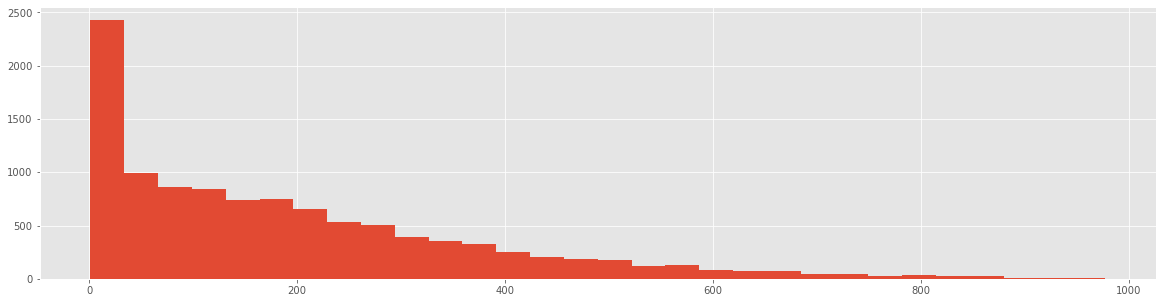

In [219]:
## 대여횟수에 따른 구간화 -> 향후 붓스트랩이 적은 관측치들에 대한 특징을 가진 학습데이터를 만들어 내는가 확인
df['count'].hist(bins = 30, figsize = (20,5))

In [220]:
# 타겟 변수를 범주형 변수로 만들기 위해 구간화 수행
ranges = [0, 50, 200, 300, 450, 600, 700, 800, 1000]
labels = ['LLLowest','Lowest', 'Low', 'Medium', 'High','Highest', 'HHHighest', 'Top']
df['count_bin'] = pd.cut(df['count'], bins=ranges,labels=labels, include_lowest=True)
df.drop('count', axis=1, inplace=True)

In [221]:
# 클래스들이 불균형하도록 설정
df['count_bin'].value_counts()

Lowest       3715
LLLowest     2969
Low          1720
Medium       1379
High          691
Highest       216
HHHighest     110
Top            86
Name: count_bin, dtype: int64

In [222]:
X = df.drop(['datetime','count_bin'], axis=1)
y = df['count_bin']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)
print('학습데이터 크기:', x_train.shape)
print('평가데이터 크기:', x_test.shape)

학습데이터 크기: (8708, 14)
평가데이터 크기: (2178, 14)


In [223]:
y_train.value_counts()

Lowest       2971
LLLowest     2375
Low          1376
Medium       1103
High          553
Highest       173
HHHighest      88
Top            69
Name: count_bin, dtype: int64

### Random Forest (RF) 적용
- RF 예측 결과 확인 (디테일한 파라미터 튜닝 x)
- 각 개별 나무들과 붓스트랩 확인

In [224]:
# 디폴트 파라미터를 사용하여 모델 fitting 및 predict
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
rf_prediction = rf.predict(x_test)

In [225]:
# 분류결과 확인
print(classification_report(y_test, rf_prediction))

              precision    recall  f1-score   support

   HHHighest       0.65      0.59      0.62        22
        High       0.90      0.88      0.89       138
     Highest       0.79      0.70      0.74        43
    LLLowest       0.99      0.99      0.99       594
         Low       0.95      0.94      0.94       344
      Lowest       0.98      0.98      0.98       744
      Medium       0.90      0.95      0.92       276
         Top       0.88      0.82      0.85        17

    accuracy                           0.96      2178
   macro avg       0.88      0.86      0.87      2178
weighted avg       0.96      0.96      0.96      2178



In [226]:
importance = rf.feature_importances_
feature = x_train.columns
importances = pd.DataFrame()
importances['feature'] = feature
importances['importances'] = importance
importances.sort_values('importances', ascending=False, inplace=True)
importances.reset_index(drop=True, inplace=True)
importances

,feature,importances
0,registered,0.517980
1,casual,0.163635
2,hour,0.126465
3,humidity,0.031116
4,atemp,0.029183
5,temp,0.027113
6,windspeed,0.020100
7,day,0.019439
8,month,0.018158
9,workingday,0.015353


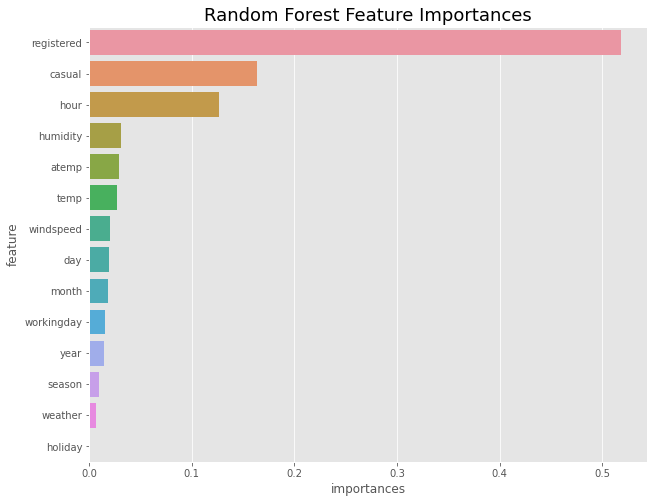

In [228]:
# 특성 중요도 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='importances', y='feature', data=importances)
plt.title('Random Forest Feature Importances', fontsize=18)
plt.show()

### EBM 적용
- EBM의 해석 결과 확인
- RF와 Extre tree의 feature importance 확인
- 변수 영향력 확인에 있어서 어떤 차이가 존재하는가?

In [237]:
from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier
ebm = ExplainableBoostingClassifier(random_state=42, n_jobs=1)
ebm.fit(x_train, y_train)

c:\Users\RohSeungChan\Anaconda3\lib\site-packages\interpret\glassbox\ebm\ebm.py:568: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions work except for global visualizations, so the line below setting interactions to zero can be disabled if you know what you are doing.
  warn("Detected multiclass problem. Forcing interactions to 0. Multiclass interactions work except for global visualizations, so the line below setting interactions to zero can be disabled if you know what you are doing.")


ExplainableBoostingClassifier(n_jobs=1)

In [240]:
ebm_global = ebm.explain_global(name = 'EBM')
show(ebm_global)

<!-- http://127.0.0.1:7001/2167442548432/ -->

![](2022-12-01-23-49-17.png)

In [242]:
ebm_local = ebm.explain_local(x_test[:4], y_test[:4], name='EBM') 
show(ebm_local)

<!-- http://127.0.0.1:7001/2167453945664/ -->

![](2022-12-01-23-49-48.png)

[해석]
- 랜덤포레스트의 feature importance와 다르게 EBM은 더 정확한 해석력을 제공한다.
    - 랜덤성 제거
    - GAM 방식의 명확한 변수별 기여도 계산
- EBM 결과 해석
    - 1번 그래프) 자전거 렌탈을 많이 하는가 아닌가를 예측하는 데 있어서 ['registered','real','casual'] 변수가 가장 중요하다는 것을 알 수 있다.
    - 2번 그래프) 1번째 test 데이터를 분류할 때 각 범주별로 관측치에 얼마나 영향을 받았는가를 보여준다. 1번 관측치를 'High' 범주로 에측하는데 있어서 ['registered','casual'] 변수가 주요하게 작용하였다.
- Multi-class일 때의 EBM 해석은 조금 더 공부를 해볼 필요가 있다.